In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import pyproj
from pyproj import Transformer
from datetime import datetime, timedelta
import os, fnmatch, glob
import cmocean 
import rasterio
from rasterio.plot import show
import sys
import geopy.distance
import pandas as pd

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#Load OMB data
OMBraw = xr.open_mfdataset('/home/maltem/work/python/data/SvalMIZ2024/cruise/2024_KVS_deployment.nc')  

In [3]:
OMBtemp = xr.open_mfdataset('/home/maltem/work/python/data/SvalMIZ2024/colocatedFiles/dataset_temp_IFS_AIFS.nc')
OMBdrift= xr.open_mfdataset('/home/maltem/work/python/data/SvalMIZ2024/colocatedFiles/dataset_TOPAZ_GOFS_RIOPS_NextSIM_ROMS00t_ROMS01t_MODIS_AMSR2_upd2.nc')


In [4]:
class StatisticalEvaluation:
    def __init__(self,buoys,models,starttime,endtime,flag,filedrift,filetemp):
        self.buoys     = buoys
        self.models    = models
        self.starttime = starttime
        self.endtime   = endtime
        self.flag      = flag      
        self.OMBdrift  = xr.open_mfdataset(filedrift)
        self.OMBtemp   = xr.open_mfdataset(filetemp)
        
    def info(self):
        print ('Evaluation of buoys',self.buoys)
        
    def teval_cond_err(self,smin,smax,sinc,leadno,cond,doplot):
           
        model=4
        bias = np.zeros(len(OMBtemp.lt_int.values)); rmse = np.zeros(len(OMBtemp.lt_int.values))
        
        # Bins For Condition 
        bins = np.arange(smin+sinc, smax, sinc)
        print(bins)
        cond_bias = np.zeros([len(bins)-1,leadno])
        cond_mae  = np.zeros([len(bins)-1,leadno])
        cond_rmse = np.zeros([len(bins)-1,leadno])
        cond_nobs = np.zeros([len(bins)-1,leadno])
        
        
        for lt in range(leadno):     
            temp_obs = [];temp_mod=[]
            sic_obs = []; sic_mod = []
        
            # Read all observations from specified buoys
            for by in range(len(self.buoys)):
                buoyno=self.buoys[by]
                
                # Find the appropriate times and their indexes within the specified range and the flagging
                time_values = OMBtemp.time_ds.values
                flag1_values= OMBtemp.temp_flag_1m[buoyno,:].values
                if self.flag==1: # Concentration based flag
                    flag2_values= OMBtemp.temp_flag_cons[buoyno,:].values    
                else:
                    flag2_values= flag1_values*0.
        
                boolean_mask = (time_values >= np.datetime64(startdate)) & (time_values <= np.datetime64(enddate)) & (flag1_values == 0.) & (flag2_values == 0)
                indexes = np.where(boolean_mask)[0]
                
                temp_obs.extend(OMBtemp.temp_1m_calibrated[buoyno,indexes].values)
                temp_mod.extend(OMBtemp.T2M[model,lt,buoyno,indexes].values)
                
                sic_obs.extend( OMBdrift.AMSR2_SIC[buoyno,indexes].values)
                sic_mod.extend(OMBtemp.SIC[model,lt,buoyno,indexes].values)
                
            temp_obs = np.array(temp_obs)-273.15; temp_mod = np.array(temp_mod)-273.15
            sic_obs = np.array(sic_obs);   sic_mod = np.array(sic_mod)

            # Non-conditional bias and RMSE
            bias[lt] = np.nanmean(temp_mod - temp_obs)
            rmse[lt] = np.sqrt(np.nanmean((temp_obs - temp_mod) ** 2))

            # -----------------------------------
            # Calculate conditional bias and RMSE
            if (cond=='sicerr'):
                sic_diff = sic_mod - sic_obs
                digitized = np.digitize(sic_diff, bins)
                xlabel = "Sea Ice Concentration Error"
            elif (cond=='sic'):
                digitized = np.digitize(sic_obs, bins)
                xlabel = "Sea Ice Concentration"
            elif (cond=='temp'):
                digitized = np.digitize(temp_obs, bins)
                xlabel = "Observed temperature"
                
            
            conditional_bias = []; conditional_rmse = []; conditional_mae = [];

            for i in range(1, len(bins)):
                
                bin_mask = digitized == i
                if np.any(bin_mask):
                    bin_temp_obs = temp_obs[bin_mask]
                    bin_temp_mod = temp_mod[bin_mask]
                    cond_nobs[i-1,lt]=len(bin_temp_obs)
                    if len(bin_temp_obs) > 0:
                        bin_bias = np.nanmean(bin_temp_mod - bin_temp_obs)
                        bin_mae  = np.nanmean(np.abs(bin_temp_mod - bin_temp_obs))
                        bin_rmse = np.sqrt(np.nanmean((bin_temp_obs - bin_temp_mod) ** 2))
                        conditional_bias.append(bin_bias)
                        conditional_mae.append(bin_mae)
                        conditional_rmse.append(bin_rmse)
                    else:
                        conditional_bias.append(np.nan)
                        conditional_mae.append(np.nan)
                        conditional_rmse.append(np.nan)
                else:
                    conditional_bias.append(np.nan)
                    conditional_mae.append(np.nan)
                    conditional_rmse.append(np.nan)

            cond_bias[:,lt] =  conditional_bias
            cond_mae[:,lt]  =  conditional_mae
            cond_rmse[:,lt] =  conditional_rmse
             
        self.bias=bias
        self.rmse=rmse
        self.cond_bias=cond_bias
        self.cond_mae =cond_mae
        self.cond_rmse=cond_rmse
        self.bins     =bins[1:len(bins)]
        bins     =bins[1:len(bins)]-sinc/2.
        
        if (doplot):
            
            fig, ax = plt.subplots(figsize=(8, 12),nrows=3,ncols=1)
            cmap = plt.get_cmap("Blues")
            norm = plt.Normalize(vmin=0, vmax=leadno)  

            for lt in range(leadno):
                color=cmap(norm(lt+1))
                ax[0].plot(bins[:],cond_bias[:,lt],marker='.',linewidth=1.5,color=color,label=OMBtemp.lt_int[lt].values)
                ax[0].plot(bins[:],cond_mae[:,lt],marker='*',linestyle='--', linewidth=1.5,color=color,label=OMBtemp.lt_int[lt].values)

            ax[0].legend()
            ax[0].set_title("Conditional Bias and MAE")
            ax[0].set_xlabel(xlabel)
            ax[0].set_ylabel("Temperature Bias and MAE")
            #ax[0].legend()

            for lt in range(leadno):
                color=cmap(norm(lt+1))
                ax[1].plot(bins[:],cond_rmse[:,lt],marker='.',linewidth=1.5,color=color,label=OMBtemp.lt_int[lt].values)

            ax[1].legend()
            ax[1].set_title("Conditional RMSE")
            ax[1].set_xlabel(xlabel)
            ax[1].set_ylabel("Temperature RMSE")
            ax[1].legend()
            plt.tight_layout()
        
            for lt in range(leadno):
                color=cmap(norm(lt+1))
                ax[2].plot(bins[:],cond_nobs[:,lt],marker='.',linewidth=1.5,color=color,label=OMBtemp.lt_int[lt].values)
            
            ax[2].legend()
            ax[2].set_title("Number of observations")
            ax[2].set_xlabel(xlabel)
            ax[2].set_ylabel("Number of Observations")
            ax[2].legend()
            plt.tight_layout()

Evaluation of buoys [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[-23 -21 -19 -17 -15 -13 -11  -9  -7  -5  -3  -1   1   3]


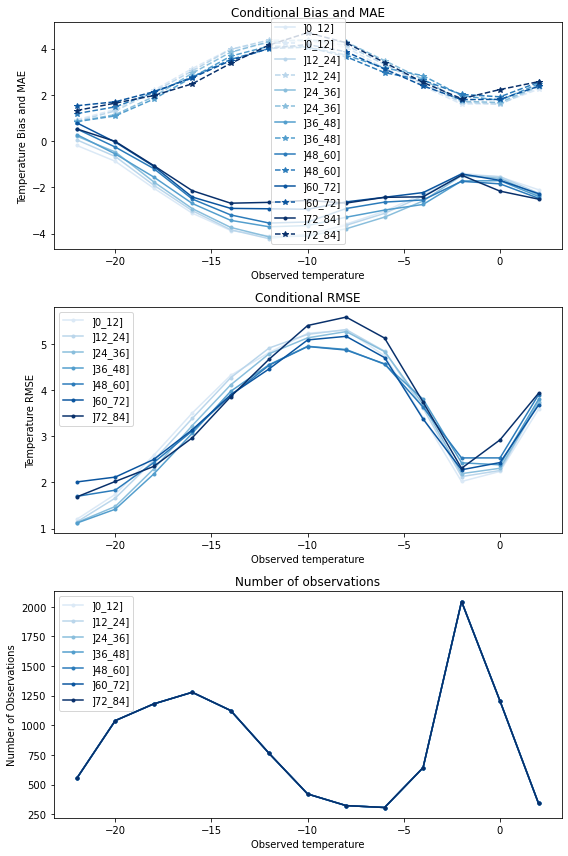

In [8]:
startdate = datetime.strptime('2024-04-04 00:00:00','%Y-%m-%d %H:%M:%S')
enddate   = datetime.strptime('2024-04-30 00:00:00','%Y-%m-%d %H:%M:%S')
ifiletemp     = '/home/maltem/work/python/data/SvalMIZ2024/colocatedFiles/dataset_temp_IFS_AIFS.nc'
ifiledrift    = '/home/maltem/work/python/data/SvalMIZ2024/colocatedFiles/dataset_TOPAZ_GOFS_RIOPS_NextSIM_ROMS00t_ROMS01t_MODIS_AMSR2_upd2.nc'

s1 = StatisticalEvaluation([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],[4],startdate,enddate,[1,1],ifiledrift,ifiletemp)
s1.info()
#s1.teval_cond_err(-0.35, 0.3, 0.05,leadno=7,cond='sicerr',doplot=True)
s1.teval_cond_err(-25, 4, 2,leadno=7,cond='temp',doplot=True)
#s1.teval_cond_err(-0., 1.2, 0.2,leadno=7,cond='sic',doplot=True)